# DCGAN

## Imports

In [1]:
from tensorflow.keras.datasets import mnist
import cv2
from datetime import datetime
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import os
from PIL import Image
import math
import yaml
from copy import deepcopy

os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'  # minimize TF annoying messages

Show TF version (2.4.0 and 2.4.1 are almost the same)

In [2]:
print(tf.__version__)
print(f"GPUs used: {tf.config.list_physical_devices('GPU')}")

2.4.1
GPUs used: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data pipeline

In [3]:
def data_pipeline_load(dataset_name, **kwargs):
    """ Create optimized data loading pipeline for training.
    Adapted from: https://cs230.stanford.edu/blog/datapipeline/,
    https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data
    
    Parameters
    ----------
    dataset_name : str
        Name of dataset, either mnist or faces.
    kwargs : dict
        Must include resize_to for both nist and faces. Must include data_directory for faces.
        If resize_to is None, the images keep their original shapes.
    
    Returns
    -------
    dataset : tf.data.Dataset
        Dataset object.
    dataset_size : int
        Number of instances in dataset. For shuffling later.
    
    Raises
    ------
    None
    
    Notes
    -----
    Dataset is not pre-processed, not shuffled, not batched and not pre-fetched yet.
    """
    resize_to = kwargs["resize_to"]
    
    if dataset_name == "mnist":
        dataset, dataset_size, img_original_shape = data_pipeline_load_mnist()
    elif dataset_name == "faces":
        data_directory= kwargs["data_directory"]
        dataset, dataset_size, img_original_shape = data_pipeline_load_faces(data_directory)
    
    resize_to = img_original_shape if resize_to is None else resize_to
    
    dataset = data_pipeline_pre_process(dataset, resize_to)
    
    print(f"loaded and pre-processed: {dataset_name}, size: {dataset_size}")
    
    return dataset, dataset_size

def data_pipeline_pre_process(dataset, resize_to):
    """ Create optimized data pre-processing pipeline for training.
    Adapted from: https://cs230.stanford.edu/blog/datapipeline/,
    https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data
    
    Parameters
    ----------
    dataset_name : str
        Name of dataset, either mnist or faces.
    resize_to : tuple
        Resize to (height, width).
    
    Returns
    -------
    dataset : tf.data.Dataset
        Dataset object.
    
    Raises
    ------
    None
    
    Notes
    -----
    Dataset is pre-processed - standardized to -1.0 - 1.0 and resized.
    But not shuffled, not batched and not pre-fetched yet.
    """
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
    
    # automatically finds good allocation of CPU budget
    dataset = dataset.map(normalization_layer, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    
    # automatically finds good allocation of CPU budget
    dataset = dataset.map(lambda im: resize_image(im, resize_to), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

def data_pipeline_pre_train(dataset, dataset_size, batch_size):
    """ Create optimized pre-training data pipeline. Shuffle, batch, and pre-fetch dataset.
    Adapted from: https://cs230.stanford.edu/blog/datapipeline/,
    https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data
    
    Parameters
    ----------
    dataset : tf.data.Dataset
        Dataset object.
    dataset_size : int
        Number of instances in dataset. For shuffling.
    batch_size : int 
        Batch size.
    
    Returns
    -------
    dataset : tensorflow.data.Dataset
        Dataset object.
    
    Raises
    ------
    None
    
    Notes
    -----
    Dataset is now pre-processed, shuffled, batched and pre-fetched yet.
    buffer_size (dataset_size) >= batch_size to get an uniform shuffle, right? idk
    """
    dataset = dataset.shuffle(dataset_size).batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset


def resize_image(image, resize_to):
    """ Resize image.
    
    Parameters
    ----------
    image : tensorflow.Tensor
        Image object.
    resize_to : tuple
        Resize to (height, width).
    
    Returns
    -------
    resized_image : tensorflow.Tensor
        Resize image object.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    resized_image = tf.image.resize(image, [resize_to[0], resize_to[1]])
    
    return resized_image


def data_pipeline_load_mnist():
    """ MNIST loading pipeline.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    dataset : tf.data.Dataset
        Dataset object.
    dataset_size : int
        Number of instances in dataset. For shuffling.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    (x_train, y_train), (_, _) = mnist.load_data()
    
    img_original_shape = (28, 28)
    
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    
    dataset = tf.data.Dataset.from_tensor_slices(x_train)
    
    # shuffle here since more difficult later
    dataset_size = len(x_train)
    
    return dataset, dataset_size, img_original_shape

def get_faces_paths(data_directory):
    """ Get the paths to the faces images.
    
    Parameters
    ----------
    data_directory : str
        Path to the faces images.
    
    Returns
    -------
    paths_faces : list
        List of paths to all images.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    paths_faces = []
        
    for idx, filename in enumerate(os.listdir(data_directory)):
        paths_face = os.path.join(data_directory, filename)
        paths_faces.append(paths_face)
    
    return paths_faces

def parse_function(filename):
    """ Parse a filename and load the corresponding image. Used for faces.
    
    Parameters
    ----------
    filename : str
        Path to the faces image.
    
    Returns
    -------
    image : tensorflow.Tensor
        Image object.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    # automatically finds good allocation of CPU budget
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    #This will convert to float values in [0, 1]
    #image = tf.image.convert_image_dtype(image, tf.float32)

    return image

def data_pipeline_load_faces(data_directory):
    """ Faces loading pipeline.
    
    Parameters
    ----------
    data_directory : str
        Path to the faces images.
    
    Returns
    -------
    dataset : tf.data.Dataset
        Dataset object.
    dataset_size : int
        Number of instances in dataset. For shuffling.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    filenames = get_faces_paths(data_directory)
    dataset_size = len(filenames)
    
    img = cv2.imread(filenames[0])
    img_original_shape = img.shape[:2]
    
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    #dataset = dataset.shuffle(len(filenames))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset, dataset_size, img_original_shape

### Check datapipelines

for faces. images should be resized to ```resize_to``` (if None, images keep their original shapes) and min-max should be -1.0 - 1.0.

In [12]:
""""
data_directory = os.path.join("../", "data", "archive", "img_align_celeba", "img_align_celeba")
# original shape = (218, 178, 3)
resize_to = (32, 32)
#resize_to = None
kwargs = {"data_directory": data_directory, "resize_to": resize_to}
dataset_name = "faces"
batch_size = 128

dataset, dataset_size = data_pipeline_load(dataset_name, **kwargs)

print(dataset)

# warning: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
# eliminate by inverse pre-processing steps during visualization
for image in dataset.take(2):
    plt.imshow(image)
    plt.show()
    print(image.shape)
    print(tf.reduce_max(image))
    print(tf.reduce_min(image))
    
dataset = data_pipeline_pre_train(dataset, dataset_size, batch_size)
"""

'"\ndata_directory = os.path.join("../", "data", "archive", "img_align_celeba", "img_align_celeba")\n# original shape = (218, 178, 3)\nresize_to = (32, 32)\n#resize_to = None\nkwargs = {"data_directory": data_directory, "resize_to": resize_to}\ndataset_name = "faces"\nbatch_size = 128\n\ndataset, dataset_size = data_pipeline_load(dataset_name, **kwargs)\n\nprint(dataset)\n\n# warning: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).\n# eliminate by inverse pre-processing steps during visualization\nfor image in dataset.take(2):\n    plt.imshow(image)\n    plt.show()\n    print(image.shape)\n    print(tf.reduce_max(image))\n    print(tf.reduce_min(image))\n    \ndataset = data_pipeline_pre_train(dataset, dataset_size, batch_size)\n'

for mnist. images should be resized to ```resize_to``` (if None, images keep their original shapes) and min-max should be -1.0 - 1.0.

loaded and pre-processed: mnist, size: 60000
<ParallelMapDataset shapes: (28, 28, 1), types: tf.float32>


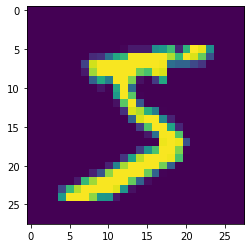

(28, 28, 1)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


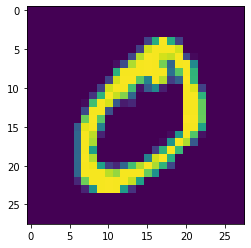

(28, 28, 1)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


In [4]:
# original shape = (28, 28, 1)
resize_to = (32, 32)
resize_to = None
kwargs = {"data_directory": None, "resize_to": resize_to}
dataset_name = "mnist"
batch_size = 128

dataset, dataset_size = data_pipeline_load(dataset_name, **kwargs)

print(dataset)

for image in dataset.take(2):
    plt.imshow(image)
    plt.show()
    print(image.shape)
    print(tf.reduce_max(image))
    print(tf.reduce_min(image))
    
dataset = data_pipeline_pre_train(dataset, dataset_size, batch_size)

## DCGAN model for MNIST

In [5]:
def conv_out_size_same(size, stride):
    """ Faces loading pipeline.
    
    Parameters
    ----------
    size : int
        Size of dimension (height or width) of layer n.
    stride : int
        Stride size in that dimension of layer n.
    
    Returns
    -------
    int
        The size of the dimension (height or width) in layer n-1 to obtain same convoltuion
        from layer n-1 to n.
    
    Raises
    ------
    None
    
    Notes
    -----
    Source:
    https://github.com/carpedm20/DCGAN-tensorflow/blob/62c9a2a7f74505cad30858bf40307c93e5bd9293/model.py#L14
    """
    return int(math.ceil(float(size) / float(stride)))

In [6]:
class DCGAN(keras.Model):
    def __init__(self, input_shape, name, **cfg):
        super(DCGAN, self).__init__(name=name)
        #self.make_generator(input_shape)
        self.cfg = cfg
        self.gen_cfg = cfg["generator"]
        #self.disc_cfg = cfg["discriminator"]
    
    def complement_gen_cfg(self, gen_cfg, output_shape):
        """ Build config for generator. Config is yaml file. 
        
        Parameters
        ----------
        gen_cfg : dict
            Generator config dict from yaml file.
        output_shape : tuple
            Height, width, channels of output feature map.

        Returns
        -------
        dict
            gen_cfg but complemented by feature map shapes (heigh, width), most importantly
            with the project-reshape z shape.

        Raises
        ------
        None

        Notes
        -----
        E.g.: the architecture in the paper (gen_cfg):
        
        generator:
          pr:
            filters: 1024
          h1:
            filters: 512
            strides: [2,2]
            kernel_size: [5,5]
          h2:
            filters: 256
            strides: [2,2]
            kernel_size: [5,5]
          h3:
            filters: 128
            strides: [2,2]
            kernel_size: [5,5]
          h4:
            filters: 3
            strides: [2,2]
            kernel_size: [5,5]
        
        and output_shape is (64,64,3).
        Then, 
        
        s_h, s_w, s_c = output_shape = (64,64,3)
        
        s_c4 = 3 -> generator["h4"]["filters"]
        s_c3 = 512 -> generator["h3"]["filters"]
        s_c2 = 256 -> generator["h2"]["filters"]
        s_c1 = 512 -> generator["h1"]["filters"]
        s_c_pr = 1024 -> generator["pr"]["filters"]
        
        s_s4 = (2, 2) -> generator["h4"]["strides"]
        s_s3 = (2, 2) -> generator["h3"]["strides"]
        s_s2 = (2, 2) -> generator["h2"]["strides"]
        s_s1 = (2, 2) -> generator["h1"]["strides"]
        
        s_f4 = (5,5) -> generator["h4"]["kernel_size"]
        s_f3 = (5,5) -> generator["h3"]["kernel_size"]
        s_f2 = (5,5) -> generator["h2"]["kernel_size"]
        s_f1 = (5,5) -> generator["h1"]["kernel_size"]
        
        s_h3, s_w3 = conv_out_size_same(s_h, s_s4[0]), conv_out_size_same(s_w, s_s4[1]) = (32,32)
        s_h2, s_w2 = conv_out_size_same(s_h3, s_s3[0]), conv_out_size_same(s_w3, s_s3[1]) = (16,16)
        s_h1, s_w1 = conv_out_size_same(s_h2, s_s2[0]), conv_out_size_same(s_w2, s_s2[1]) = (8,8)
        s_h_pr, s_w_pr = conv_out_size_same(s_h1, s_s1[0]), conv_out_size_same(s_w1, s_s1[1]) = (4,4)
        
        where e.g.: s_h3, s_w3 is the feature map shape (h,w) in the 3rd upsampling conv2
        and s_h_pr, s_w_pr is the shape (h,w) of the project-reshape on z.
        Each hx layer is an upsampling conv2d layer.
        
        Note that upsampling conv2d is always same convolution.
        The whole point of this function is to obtain the feature map shapes and the project-reshape z
        shape from the output_shape, the number of filters (filters), the stride size (strides),
        and the kernel sizes.
        """
        # Get output shape.
        s_h, s_w, s_c = output_shape
        
        # Get the layer keys.
        keys = list(gen_cfg.keys())
        keys_reversed = list(reversed(keys))
        
        # Set temp variables.
        s_hx = s_h
        s_wx = s_w
        
        # Reverse iterate through layers.
        for idx, k in enumerate(keys_reversed):
            # if project-reshape z (layer no. 0), then set the last layer 
            # (layer before pr in reverse, last list element) feature map shape
            if k == "pr":
                gen_cfg[keys_reversed[0]]["s_h"] = s_h
                gen_cfg[keys_reversed[0]]["s_w"] = s_w
                # exit loop
                continue
            
            # get stride size
            s_sx = gen_cfg[k]["strides"]
            
            # get feature map shape
            s_hx, s_wx = \
                conv_out_size_same(s_hx, s_sx[0]), conv_out_size_same(s_wx, s_sx[1])
            
            # set the feature map shape in the layer before based on the current layer
            gen_cfg[keys_reversed[idx+1]]["s_h"] = s_hx
            gen_cfg[keys_reversed[idx+1]]["s_w"] = s_wx
            
        return deepcopy(gen_cfg) 
    
    def make_generator(self, input_shape, output_shape):
        """ Make the generator model. Note that depending on the dataset, the feature map shapes,
        kernel sizes, and channels will change. Encapsulated config in yaml file to automatically
        do this.
    
        Parameters
        ----------
        input_shape : tuple
            Input image shape, height, width, channels.
        output_shape : tuple
            Output image shape, height, width, channels.

        Returns
        -------
        keras.Model
            The generator model.

        Raises
        ------
        None

        Notes
        -----
        None
        """
        # complement the generator config with the feature map shapes, and
        # most importantly with the proejct-reshape z shape.
        gen_cfg = self.complement_gen_cfg(self.gen_cfg, output_shape)
        
        # take care of input z (!!)
        # Functional API for more flexibility
        inputs = keras.Input(shape=input_shape, name="generator_input")
        
        # NOTE: Number of filters should be adapted to each dataset <- FIND WAY TO DO IT AUTOMATICALLY
        # idea: define build_mnist_generator() and use that in if else
        # project `z` and reshape
        s_h_pr = gen_cfg["pr"]["s_h"]
        s_w_pr = gen_cfg["pr"]["s_w"]
        s_c_pr = gen_cfg["pr"]["filters"]
        z_proj = layers.Dense(s_h_pr*s_w_pr*s_c_pr, use_bias=False, name="g_h0_lin")(inputs)
        h = layers.Reshape((s_h_pr, s_w_pr, s_c_pr), name="g_h0")(z_proj)
        h = layers.BatchNormalization(name="g_h0_bn")(h)
        h = layers.LeakyReLU(name="g_h0_a")(h)
        
        # Note: None is the batch size
        assert tuple(h.shape) == (None, s_h_pr, s_w_pr, s_c_pr)
        
        # get layer keys
        keys = list(gen_cfg.keys())
        
        # iterate through the layers from the beginning
        # skip project-reshape z, and deal with last upsample conv2d later
        for k in keys[1:-1]:
            # upsample conv2d layer
            s_c = gen_cfg[k]["filters"]
            s_s = gen_cfg[k]["strides"]
            s_f = gen_cfg[k]["kernel_size"]
            
            h = layers.Conv2DTranspose(filters=s_c, 
                                       kernel_size=s_f, 
                                       strides=s_s, 
                                       padding='same', 
                                       use_bias=False, 
                                       name=f"g_{k}")(h)

            h = layers.BatchNormalization(name=f"g_{k}_bn")(h)
            h = layers.LeakyReLU(name=f"g_{k}_a")(h)
            
            s_h = gen_cfg[k]["s_h"]
            s_w = gen_cfg[k]["s_w"]
            
            assert tuple(h.shape) == (None, s_h, s_w, s_c)

        # upsample conv2d last layer
        k = keys[-1]
        s_c = gen_cfg[k]["filters"]
        s_s = gen_cfg[k]["strides"]
        s_f = gen_cfg[k]["kernel_size"]
        
        h = layers.Conv2DTranspose(filters=s_c, 
                                   kernel_size=s_f, 
                                   strides=s_s, 
                                   padding='same', 
                                   use_bias=False, 
                                   activation='tanh',
                                   name=f"g_{k}")(h)
        
        s_h = gen_cfg[k]["s_h"]
        s_w = gen_cfg[k]["s_w"]
        
        assert tuple(h.shape) == (None, s_h, s_w, s_c)
        
        self.generator = tf.keras.Model(inputs=inputs, outputs=h, name="generator")
        
        return self.generator

    def make_discriminator(self, output_shape):
        """ Make the discriminator model. Model is fixed (at least for now).
        Can go down from arbitrary output_shape to sigmoid prediciton.
    
        Parameters
        ----------
        output_shape : tuple
            Output image shape, height, width, channels.

        Returns
        -------
        keras.Model
            The discriminator model.

        Raises
        ------
        None

        Notes
        -----
        None
        """
        outputs = keras.Input(shape=output_shape, name="discriminator_input")
        
        h = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',name="d_h0")(outputs)
        h = layers.LeakyReLU()(h)
        h = layers.Dropout(0.3)(h)

        h = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name="d_h1")(h)
        h = layers.LeakyReLU()(h)
        h = layers.Dropout(0.3)(h)

        h = layers.Flatten(name="d_h2_lin")(h)
        h = layers.Dense(1)(h)
        
        self.discriminator = tf.keras.Model(inputs=outputs, outputs=h, name="discriminator")

        return self.discriminator
    
    def evaluate_loss(self,real_images,fake_images,type):
        '''
                Generator -> Goal is to generate the "realest" fake images, so the loss is only measured taking those in consideration.

                Discriminator -> We want the output to be 1 for real images and 0 for fake images. 
                Here, the total loss will be aggregated loss for real and fake images (which is obvious because we're trying 
                to see how these compare)

        '''
        f_loss = keras.losses.binary_crossentropy(from_logits=True)
        if type == 'generator':
            return f_loss(tf.ones_like(fake_images),fake_images).numpy()    # transform fake images array into an array of ones
        elif type == 'discriminator':
            return f_loss(tf.ones_like(real_images),real_images).numpy() + f_loss(tf.zeros_like(fake_images),fake_images).numpy()

    def optimize(learning_rate=0.0002,beta1=0.5):
        '''
            According to the original DCGAN paper(*): 
                1) Learning rate - " While previous GAN work has used momentum to accelerate training, 
            we used the Adam optimizer (Kingma & Ba, 2014) with tuned hyperparameters. We found the suggested learning 
            rate of 0.001, to be too high, using 0.0002 instead."

                2) Momentum (beta1) - "Additionally, we found leaving the momentum term β1 at the suggested value of 0.9 resulted
                 in training oscillation and instability while reducing it to 0.5 helped stabilize training.


            (*) https://arxiv.org/pdf/1511.06434.pdf


            Output:
                Optimizer for both generator and discriminator model
        '''
        return keras.optimizers.Adam(learning_rate,beta_1=beta1), keras.optimizers.Adam(learning_rate,beta_1=beta1)

In [8]:
with open("config_tf_example.yml", 'r') as stream:
    try:
        cfg = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

input_shape = (100,)
output_shape = (28, 28, 1)


dcgan = DCGAN(input_shape=input_shape, name="my_dcgan", **cfg)

generator = dcgan.make_generator(input_shape, output_shape)

print(generator.summary())

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=True)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = dcgan.make_discriminator(output_shape)
decision = discriminator(generated_image)
print(decision)

print(discriminator.summary())

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
g_h0_lin (Dense)             (None, 12544)             1254400   
_________________________________________________________________
g_h0 (Reshape)               (None, 7, 7, 256)         0         
_________________________________________________________________
g_h0_bn (BatchNormalization) (None, 7, 7, 256)         1024      
_________________________________________________________________
g_h0_a (LeakyReLU)           (None, 7, 7, 256)         0         
_________________________________________________________________
g_h1 (Conv2DTranspose)       (None, 7, 7, 128)         819200    
_________________________________________________________________
g_h1_bn (BatchNormalization) (None, 7, 7, 128)         51

NotFoundError: No algorithm worked! [Op:Conv2DBackpropInput]

In [9]:
with open("config_paper.yml", 'r') as stream:
    try:
        cfg = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

input_shape = (100,)
output_shape = (64, 64, 3)


dcgan = DCGAN(input_shape=input_shape, name="my_dcgan", **cfg)

generator = dcgan.make_generator(input_shape, output_shape)

print(generator.summary())

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = dcgan.make_discriminator(output_shape)
decision = discriminator(generated_image)
print(decision)

print(discriminator.summary())

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
g_h0_lin (Dense)             (None, 16384)             1638400   
_________________________________________________________________
g_h0 (Reshape)               (None, 4, 4, 1024)        0         
_________________________________________________________________
g_h0_bn (BatchNormalization) (None, 4, 4, 1024)        4096      
_________________________________________________________________
g_h0_a (LeakyReLU)           (None, 4, 4, 1024)        0         
_________________________________________________________________
g_h1 (Conv2DTranspose)       (None, 8, 8, 512)         13107200  
_________________________________________________________________
g_h1_bn (BatchNormalization) (None, 8, 8, 512)         20

NotFoundError: No algorithm worked! [Op:Conv2DBackpropInput]

In [1]:
with open("config_custom.yml", 'r') as stream:
    try:
        cfg = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

input_shape = (100,)
output_shape = (128, 128, 3)


dcgan = DCGAN(input_shape=input_shape, name="my_dcgan", **cfg)

generator = dcgan.make_generator(input_shape, output_shape)

print(generator.summary())

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = dcgan.make_discriminator(output_shape)
decision = discriminator(generated_image)
print(decision)

print(discriminator.summary())

NameError: name 'yaml' is not defined